In [ ]:
!pip install svetlanna
!pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas

### Импорт библиотек

In [1]:
import os
import sys
import random

In [2]:
import time

In [3]:
import numpy as np

In [4]:
import torch
from torch.utils.data import Dataset

In [5]:
from torch import nn

In [6]:
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as functional

In [7]:
from torchvision.transforms import InterpolationMode

In [8]:
from svetlanna import SimulationParameters
from svetlanna.parameters import BoundedParameter

In [9]:
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.setup import LinearOpticalSetup
from svetlanna.detector import Detector, DetectorProcessorClf

In [10]:
from svetlanna.transforms import ToWavefront

In [11]:
from src.wf_datasets import DatasetOfWavefronts
from src.wf_datasets import WavefrontsDatasetSimple

In [12]:
from tqdm import tqdm

In [13]:
from datetime import datetime

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# 4F система

В данном примере мы обучим [4F систему](https://www.science.org/doi/10.1126/science.aat8084) на случайно сгенерированном датасете.

# 1. Параметры моделирования

In [15]:
c_const = 299_792_458  # [m / s]

In [16]:
working_wavelength = 10 * 1e-6  # [m]
print(f'lambda = {working_wavelength * 1e6:.3f} um')

lambda = 10.000 um


In [17]:
# Физический размер волнового фронта — (1 × 1) [см]
x_mesh_size_m = 2 * 1e-2  # [m]
y_mesh_size_m = x_mesh_size_m

In [18]:
#количество нейронов в симуляции

mesh_step_size_m = 5 * 1e-5  # [m]

x_mesh_nodes = int(x_mesh_size_m / mesh_step_size_m)
y_mesh_nodes = int(y_mesh_size_m / mesh_step_size_m)

In [19]:
print(f'Mesh size: {x_mesh_nodes} x {y_mesh_nodes} = {x_mesh_nodes * y_mesh_nodes}')

Mesh size: 400 x 400 = 160000


In [20]:

SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_mesh_size_m / 2, x_mesh_size_m / 2, x_mesh_nodes),
        'H': torch.linspace(-y_mesh_size_m / 2, y_mesh_size_m / 2, y_mesh_nodes),
        'wavelength': working_wavelength,  # only one wavelength!
    }
)

# 2. Подготовка датасета


Генерация датасета волновых фронтов со случайными распределениями интенсивности

## 2.1. Целевая 4F - система

In [21]:
TARGET_F = 4 * 1e-2  # in [m]

LENS_RADII = 2 * 1e-2  # in [m]
FREESPACE_METHOD = 'AS'

In [22]:
# list of elements for a target 4f system
TARGET_4F_LIST = [
    elements.FreeSpace(
        simulation_parameters=SIM_PARAMS,
        distance=TARGET_F,
        method=FREESPACE_METHOD
    ),
    elements.ThinLens(  # first lens
        simulation_parameters=SIM_PARAMS,
        focal_length=TARGET_F,
        radius=LENS_RADII
    ),
    elements.FreeSpace(
        simulation_parameters=SIM_PARAMS,
        distance=2 * TARGET_F,
        method=FREESPACE_METHOD
    ),
    elements.ThinLens(  # second lens
        simulation_parameters=SIM_PARAMS,
        focal_length=TARGET_F,
        radius=LENS_RADII
    ),
    elements.FreeSpace(
        simulation_parameters=SIM_PARAMS,
        distance=TARGET_F,
        method=FREESPACE_METHOD
    ),
    Detector(  # detector that returns tensor of intensities
        simulation_parameters=SIM_PARAMS,
        func='intensity'
    )
]

In [23]:
TARGET_4F_SYSTEM = LinearOpticalSetup(
    elements=TARGET_4F_LIST
)

## 2.2. Dataset class

In [ ]:
class RandomPixelsWavefronts(Dataset):
    """
    Подход, основанный на освещении апертуры формы изображения.
    """
    def __init__(
        self,
        image_size_m,  # (h, w) in [m]
        image_size_pixels,  # (n_y, n_x)
        target_setup : LinearOpticalSetup,
        sim_params: SimulationParameters,
    ):
        """
        Параметры
        ----------

        sim_params : SimulationParameters
            Параметры симуляции для последующей оптической нейросети.
        ...

        """
        self.sim_params = sim_params # для проверки, приводят ли все преобразования к правильной форме
        self.image_size_pixels = image_size_pixels
        self.pixels_number = self.image_size_pixels[0] * self.image_size_pixels[1]

        m_to_mesh_nodes_y = len(SIM_PARAMS.axes.H) / (SIM_PARAMS.axes.H[-1] - SIM_PARAMS.axes.H[0]).item()
        m_to_mesh_nodes_x = len(SIM_PARAMS.axes.W) / (SIM_PARAMS.axes.W[-1] - SIM_PARAMS.axes.W[0]).item()
        self.image_size_mesh_nodes = (
            int(image_size_m[0] * m_to_mesh_nodes_y),
            int(image_size_m[1] * m_to_mesh_nodes_x)
        )  # size of all pixels in mesh nodes

        self.target_setup = target_setup

    def __len__(self):
        return 2 ** (self.pixels_number)

    def __getitem__(self, ind: int) -> tuple:
        """
        Параметры
        ----------
        ind : int
            Индекс возвращаемого элемента.

        Возвращает
        ----------
        tuple
            Элемент датасета: кортеж (Wavefront, Tensor)
            Размер волнового фронта должен соответствовать параметрам симуляции!
        """

        # создать входной волновой фронт

        # индекс как генератор случайных чисел [метод 1]
        # pixels_set = torch.randint(
        #     2, size=(9,),
        #     generator=torch.Generator().manual_seed(ind)  # используем ind как генератор для воспроизводимости
        # ).resize_(self.image_size_pixels)

        # каждый пиксель устанавливается на основе бинаризованного индекса [метод 2]

        pixels_set = torch.tensor(
            list(
                map(
                    int,
                    '0' * (self.pixels_number - len(bin(ind)[2:])) + bin(ind)[2:])
            ),
            dtype=torch.float32
        ).resize_(self.image_size_pixels)

        pixels_image = functional.interpolate(
            pixels_set[None, None, ...],
            size=self.image_size_mesh_nodes
        )[0][0]

        # добавление паддинга
        y_nodes, x_nodes = self.sim_params.axes_size(axs=('H', 'W'))
        y_img, x_img = self.image_size_mesh_nodes

        if (not y_nodes == y_img) or (not x_nodes == x_img):
            # добавляем паддинг для соответствия размерам симуляции
            # симметрично!
            pad_top = int((y_nodes - y_img) / 2)
            pad_bottom = y_nodes - pad_top - y_img
            pad_left = int((x_nodes - x_img) / 2)
            pad_right = x_nodes - pad_left - x_img  # параметры для transforms.Pad

            # трансформация с паддингом для согласования размера апертуры с параметрами симуляции
            pixels_image = functional.pad(
                input=pixels_image,
                pad=(pad_left, pad_right, pad_top, pad_bottom),
                mode='constant',
                value=0
            )

        # преобразование тензора в волновой фронт
        pixels_wf = ToWavefront(modulation_type='amp').forward(pixels_image)

        # вычисление целевого волнового фронта на основе self.target_setup
        self.target_setup.net.eval()
        # target = pixels_wf
        with torch.no_grad():
            # for el in self.target_setup.net:
            #     target = el.forward(target)
            #     print(f'{type(el).__name__}: {target.size()}')
            target = self.target_setup.forward(pixels_wf)

        return pixels_wf, target


### 2.2.1. Датасет с изображениями

In [25]:
PIXELS_DS = RandomPixelsWavefronts(
    (0.5 * 1e-2, 0.5 * 1e-2),  # (h, w) in [m]
    (3, 3),  # (n_y, n_x)
    TARGET_4F_SYSTEM,
    SIM_PARAMS,
)

In [26]:
print(f'Dataset size: {len(PIXELS_DS)}')

Dataset size: 512


### 2.2.2. Визуализация нескольких примеров из датасета

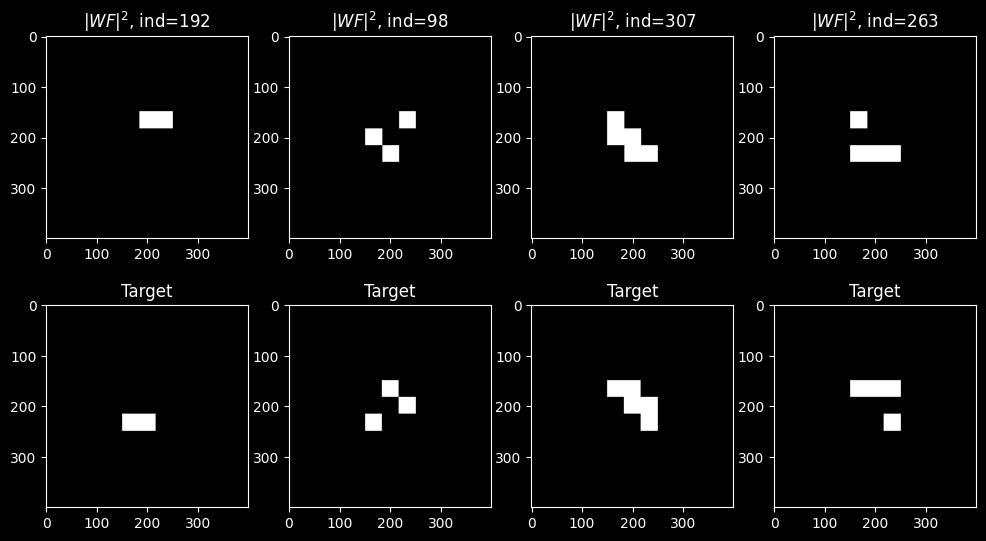

In [ ]:
# визуализация нескольких ПРИМЕРОВ из тренировочного датасета
n_examples = 4  # количество примеров для отображения
# выбор индексов изображений (из train) для отображения
random.seed(78)
examples_ids = random.sample(range(len(PIXELS_DS)), n_examples)

n_lines = 2
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))

for ind_ex, ind_sample in enumerate(examples_ids):

    wavefront, target = PIXELS_DS[ind_sample]

    axs[0][ind_ex].set_title(f'$|WF|^2$, ind={ind_sample}')
    # здесь мы можем отобразить интенсивность волнового фронта
    axs[0][ind_ex].imshow(
        wavefront.intensity, cmap='gray',
        vmin=0, vmax=1
    )

    axs[1][ind_ex].set_title('Цель')
    axs[1][ind_ex].imshow(
        target, cmap='gray',
        vmin=0, vmax=1
    )

plt.show()


## 2.3. Разделение датасета на обучающую и тестовую выборки

In [28]:
train_size = int(0.8 * len(PIXELS_DS))

DATA_SPLIT_SEED = 178

In [ ]:
train_set, val_set = torch.utils.data.random_split(
    PIXELS_DS,
    [train_size, len(PIXELS_DS) - train_size],
    generator=torch.Generator().manual_seed(DATA_SPLIT_SEED)

In [30]:
print(f'Train data: {len(train_set)}')
print(f'Test data : {len(val_set)}')

Train data: 409
Test data : 103


# 3. Оптическая нейросеть для обучения


## 3.1. Список элементов

In [31]:
DISTANCE_MAX = 10 * 1e-2  # [м] – верхняя граница для оптимизации расстояний
DISTANCE_MIN = 1 * 1e-2   # [м] – нижняя граница для оптимизации расстояний

F_MAX = 10 * 1e-2  # [м] – верхняя граница для оптимизации фокусных расстояний
F_MIN = 1 * 1e-2   # [м] – нижняя граница для оптимизации фокусных расстояний


In [32]:
# значения для инициализации обучаемой системы
INIT_DISTANCES = [2 * 1e-2, 2 * 1e-2, 4 * 1e-2]
INIT_F = [5 * 1e-2, 6.5 * 1e-2]


In [ ]:
def get_elements_list(
    distances,
    focal_lengths,
    simulation_parameters,
    freespace_method,
):
    """
    Формирует список элементов для оптической системы.
        Оптическая система: FS|ThinLens|FS|ThinLens|FS|Detector
    ...

    Параметры
    ----------
    distances : list[float]
        Список из трёх расстояний для инициализации FreeSpace (в метрах).
    focal_lengths : list[float]
        Список фокусных расстояний для инициализации ThinLens (в метрах).
    simulation_parameters : SimulationParameters()
        Параметры симуляции для задачи.
    freespace_method : str
        Метод распространения для свободного пространства в системе.

    Возвращает
    ----------
    elements_list : list(Element)
        Список элементов для оптической системы.
    """

    return [
        elements.FreeSpace(
            simulation_parameters=simulation_parameters,
            distance=BoundedParameter(
                distances[0],
                min_value=DISTANCE_MIN,
                max_value=DISTANCE_MAX
            ),
            method=freespace_method
        ),
        elements.ThinLens(  # первая линза
            simulation_parameters=simulation_parameters,
            focal_length=BoundedParameter(
                focal_lengths[0],
                min_value=F_MIN,
                max_value=F_MAX
            ),
            radius=LENS_RADII  # радиус линзы не обучаемый
        ),
        elements.FreeSpace(
            simulation_parameters=simulation_parameters,
            distance=BoundedParameter(
                distances[1],
                min_value=DISTANCE_MIN,
                max_value=DISTANCE_MAX
            ),
            method=freespace_method
        ),
        elements.ThinLens(  # вторая линза
            simulation_parameters=simulation_parameters,
            focal_length=BoundedParameter(
                focal_lengths[1],
                min_value=F_MIN,
                max_value=F_MAX
            ),
            radius=LENS_RADII  # радиус линзы не обучаемый
        ),
        elements.FreeSpace(
            simulation_parameters=simulation_parameters,
            distance=BoundedParameter(
                distances[2],
                min_value=DISTANCE_MIN,
                max_value=DISTANCE_MAX
            ),
            method=freespace_method
        ),
        Detector(  # детектор, возвращающий тензор интенсивностей
            simulation_parameters=simulation_parameters,
            func='intensity'
        )
    ]


## 3.2. Установка для тренеровки

In [34]:
def get_setup(simulation_parameters):
    """
    Возвращает оптическую установку. Все элементы создаются заново.
    """
    elements_list = get_elements_list(
        distances=INIT_DISTANCES,
        focal_lengths=INIT_F,
        simulation_parameters=SIM_PARAMS,
        freespace_method=FREESPACE_METHOD,
    )  # пересоздание списка элементов

    return LinearOpticalSetup(elements=elements_list)


In [35]:
trainable_setup = get_setup(SIM_PARAMS)
trainable_setup.net

Sequential(
  (0): FreeSpace()
  (1): ThinLens()
  (2): FreeSpace()
  (3): ThinLens()
  (4): FreeSpace()
  (5): Detector()
)

### 3.2.1. Пример распространения волнового фронта

In [36]:
example_wf = train_set[112][0]

In [37]:
setup_scheme, wavefronts = trainable_setup.stepwise_forward(example_wf)

-(0)-> [1. FreeSpace] -(1)-> [2. ThinLens] -(2)-> [3. FreeSpace] -(3)-> [4. ThinLens] -(4)-> [5. FreeSpace] -(5)-> [6. Detector] -(6)->


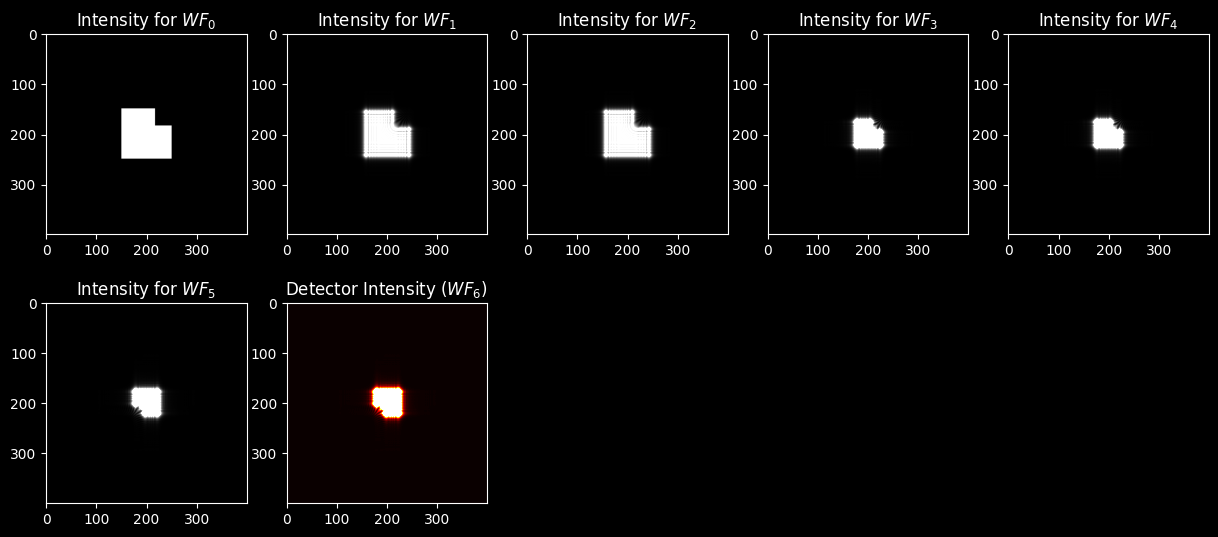

In [38]:
print(setup_scheme)  # вывод схемы распространения

n_cols = 5  # количество столбцов для отображения всех волновых фронтов во время распространения
n_rows = 2

to_plot = 'amp'  # <--- выбрать, что отображать: 'amp' или 'phase'
cmap = 'grey'  # цветовая карта для волновых фронтов
detector_cmap = 'hot'  # цветовая карта для детектора
max_intensity = 1  # максимальная интенсивность для нормализации

# создаём фигуру с подграфиками
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))

# отключаем лишние оси
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= len(wavefronts):
            ax_this.axis('off')

# отображаем волновые фронты
for ind_wf, wavefront in enumerate(wavefronts):
    ax_this = axs[ind_wf // n_cols][ind_wf % n_cols]

    if to_plot == 'phase':
        # отображаем фазу волновых фронтов
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title(f'Фаза $WF_{{{ind_wf}}}$')
            ax_this.imshow(
                wavefront.phase.detach().numpy(), cmap=cmap,
                # vmin=0, vmax=2 * torch.pi
            )
        else:
            ax_this.set_title(f'Фаза детектора ($WF_{{{ind_wf}}}$)')
            # У детектора нет фазы!

    if to_plot == 'amp':
        # отображаем интенсивность волновых фронтов
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title(f'Интенсивность $WF_{{{ind_wf}}}$')
            ax_this.imshow(
                wavefront.intensity.detach().numpy(), cmap=cmap,
                vmin=0, vmax=max_intensity
            )
        else:  # вывод детектора (не волновой фронт)
            ax_this.set_title(f'Интенсивность детектора ($WF_{{{ind_wf}}}$)')
            ax_this.imshow(
                wavefront.detach().numpy(), cmap=detector_cmap,
                vmin=0, vmax=max_intensity
            )

    # Примечание: вывод детектора — это тензор! У него нет методов волнового фронта (.phase или .intensity)

plt.show()


### 3.2.2. 

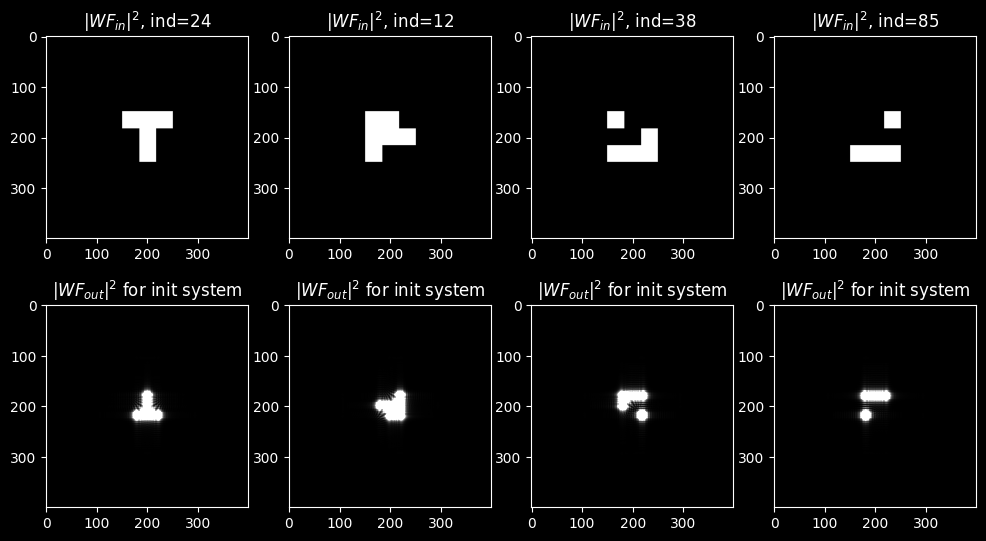

In [ ]:
# выбор индексов изображений (из валидационного набора) для отображения
random.seed(78)
val_examples_ids = random.sample(range(len(val_set)), n_examples)

n_lines = 2
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))

for ind_ex, ind_sample in enumerate(val_examples_ids):

    wavefront, target = val_set[ind_sample]

    axs[0][ind_ex].set_title('$|WF_{in}|^2$, ' + f'ind={ind_sample}')
    # отображение интенсивности входного волнового фронта
    axs[0][ind_ex].imshow(
        wavefront.intensity, cmap='gray',
        vmin=0, vmax=1
    )

    # вывод обучаемой (инициализированной) сети
    with torch.no_grad():
        output = get_setup(SIM_PARAMS).net(wavefront)
    axs[1][ind_ex].set_title('$|WF_{out}|^2$ для инициализированной системы')
    axs[1][ind_ex].imshow(
        output, cmap='gray',
        vmin=0, vmax=1
    )

plt.show()


# 4. Обучение нейросети

Переменные на данный момент:
- расстояния между `ThinLens` (размеры участков `FreeSpace`)
- фокусные расстояния линз (`ThinLenses`)


In [39]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# if DEVICE == torch.device('cpu'):
#     DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

DEVICE

device(type='cpu')

## 4.1. Подготовка процессов перед обучением системы

### 4.1.1. Инициализация объектов  DataLoader

In [40]:
train_bs = 4  # a batch size for training set
val_bs = 10

In [41]:
train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=train_bs,
        shuffle=True,
        # num_workers=2,
        drop_last=False,
    )

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=val_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

### 4.1.2. Функция потерь

In [42]:
# optimizer_clf = torch.optim.Adam(
#     params=lin_optical_setup.net.parameters()  # параметры сети!
# )

In [43]:
loss_func = nn.MSELoss()
loss_func_name = 'MSE'

### 4.1.3. Циклы обучения и оценки

In [ ]:
def onn_train_loop(
    optical_net, wavefronts_dataloader,
    loss_func, optimizer,
    device='cpu', show_process=False
):
    """
    Функция для обучения `optical_net`
    ...

    Параметры
    ----------
        optical_net : torch.nn.Module
            Нейросеть, состоящая из оптических элементов.
        wavefronts_dataloader : torch.utils.data.DataLoader
            Даталоадер (по батчам) для обучающего набора волновых фронтов.
        loss_func :
            Функция потерь для задачи.
        optimizer : torch.optim
            Оптимизатор.
        device : str
            Устройство для вычислений.
        show_process : bool
            Флаг для отображения прогресс-бара.

    Возвращает
    ----------
        batches_losses : list[float]
            Потери (loss) для каждого батча в эпохе.
    """
    optical_net.train()  # активируем режим обучения модели
    batches_losses = []  # для хранения потерь по каждому батчу

    for batch_wavefronts, batch_targets in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='обучение', position=0,
        leave=True, disable=not show_process
    ):  # проход по батчам
        # batch_wavefronts — входные волновые фронты, batch_targets — целевые изображения
        batch_size = batch_wavefronts.size()[0]

        batch_wavefronts = batch_wavefronts.to(device)
        batch_targets = batch_targets.to(device)

        optimizer.zero_grad()

        # прямой проход через оптическую нейросеть
        detector_outputs = optical_net(batch_wavefronts)
        # вычисление функции потерь по батчу — сравнение двух изображений
        loss = loss_func(detector_outputs, batch_targets)

        loss.backward()
        optimizer.step()

        # накопление потерь для каждого батча
        batches_losses.append(loss.item())

    return batches_losses


In [ ]:
def onn_validate_loop(
    optical_net, wavefronts_dataloader,
    loss_func,
    device='cpu', show_process=False
):
    """
    Функция для валидации `optical_net` (например, в задаче классификации)
    ...

    Параметры
    ----------
        optical_net : torch.nn.Module
            Нейросеть, составленная из оптических элементов.
        wavefronts_dataloader : torch.utils.data.DataLoader
            Даталоадер (по батчам) для валидационного набора волновых фронтов.
        loss_func :
            Функция потерь для задачи (например, многоклассовой классификации или регрессии).
        device : str
            Устройство для вычислений.
        show_process : bool
            Флаг для отображения прогресс-бара.

    Возвращает
    ----------
        batches_losses : list[float]
            Потери для каждого батча в эпохе.
    """
    optical_net.eval()  # включаем режим валидации
    batches_losses = []  # список для хранения потерь по батчам

    for batch_wavefronts, batch_targets in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='валидация', position=0,
        leave=True, disable=not show_process
    ):
        # batch_wavefronts — входные волновые фронты, batch_targets — целевые изображения
        batch_size = batch_wavefronts.size()[0]

        batch_wavefronts = batch_wavefronts.to(device)
        batch_targets = batch_targets.to(device)

        with torch.no_grad():
            detector_outputs = optical_net(batch_wavefronts)
            # вычисляем loss для текущего батча
            loss = loss_func(detector_outputs, batch_targets)

        # сохраняем loss
        batches_losses.append(loss.item())

    return batches_losses


## 4.2. Обучение оптической нейросети

### 4.2.1. До начала обучения

#### Метрики для обучающего и валидационного датасетов

In [46]:
# lin_optical_setup.net = lin_optical_setup.net.to(DEVICE)
# SIM_PARAMS = SIM_PARAMS.to(DEVICE)

In [ ]:
train_losses_init = onn_validate_loop(
    trainable_setup.net,  # оптическая сеть, собранная на этапе 3
    train_loader,         # загрузчик обучающего набора данных
    loss_func,
    device=DEVICE,
    show_process=True,
)  # оценка модели

print(
    'Результаты до начала обучения на TRAIN наборе:\n' +
    f'\t{loss_func_name} : {np.mean(train_losses_init):.6f}'
)


validation: 100%|██████████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 21.20it/s]

Results before training on TRAIN set:
	MSE : 0.071396


### 4.2.2. Обучение

In [ ]:
n_epochs = 100
print_each = 25

In [ ]:
scheduler = None

In [56]:
# Пересоздание системы для перезапуска обучения!

trainable_setup = get_setup(SIM_PARAMS)

# Привязка оптимизатора к пересозданной сети!
optimizer = torch.optim.Adam(
    params=trainable_setup.net.parameters()  # ПАРАМЕТРЫ НЕЙРОСЕТИ!
)


In [57]:
trainable_setup.net = trainable_setup.net.to(DEVICE)

In [ ]:
train_epochs_losses = []
val_epochs_losses = []  # для хранения потерь по эпохам

torch.manual_seed(98)  # для воспроизводимости

for epoch in range(n_epochs):
    if (epoch == 0) or ((epoch + 1) % print_each == 0):
        print(f'Эпоха #{epoch + 1}: ', end='')
        show_progress = True
    else:
        show_progress = False

    # ОБУЧЕНИЕ
    start_train_time = time.time()  # время начала эпохи (обучение)
    train_losses = onn_train_loop(
        trainable_setup.net,  # оптическая сеть, собранная на этапе 3
        train_loader,         # загрузчик обучающего набора
        loss_func,
        optimizer,
        device=DEVICE,
        show_process=show_progress,
    )  # обучение модели
    mean_train_loss = np.mean(train_losses)

    if (epoch == 0) or ((epoch + 1) % print_each == 0):  # вывод информации по обучению
        print('Результаты обучения')
        print(f'\t{loss_func_name} : {mean_train_loss:.6f}')
        print(f'\t------------   {time.time() - start_train_time:.2f} с')

    # ВАЛИДАЦИЯ
    start_val_time = time.time()  # время начала эпохи (валидация)
    val_losses = onn_validate_loop(
        trainable_setup.net,  # оптическая сеть, собранная на этапе 3
        val_loader,           # загрузчик валидационного набора
        loss_func,
        device=DEVICE,
        show_process=show_progress,
    )  # оценка модели
    mean_val_loss = np.mean(val_losses)

    if (epoch == 0) or ((epoch + 1) % print_each == 0):  # вывод информации по валидации
        print('Результаты валидации')
        print(f'\t{loss_func_name} : {mean_val_loss:.6f}')
        print(f'\t------------   {time.time() - start_val_time:.2f} с')

    if scheduler:
        scheduler.step(mean_val_loss)

    # сохраняем потери
    train_epochs_losses.append(mean_train_loss)
    val_epochs_losses.append(mean_val_loss)


Epoch #1: 

train: 100%|███████████████████████████████████████████████████████████████████████████████| 103/103 [00:07<00:00, 13.13it/s]


Training results
	MSE : 0.054001
	------------   7.85 s


validation: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  9.37it/s]


Validation results
	MSE : 0.040549
	------------   1.18 s
Epoch #25: 

train: 100%|███████████████████████████████████████████████████████████████████████████████| 103/103 [00:12<00:00,  8.24it/s]


Training results
	MSE : 0.004803
	------------   12.51 s


validation: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  5.90it/s]


Validation results
	MSE : 0.004774
	------------   1.87 s
Epoch #50: 

train: 100%|███████████████████████████████████████████████████████████████████████████████| 103/103 [00:10<00:00,  9.52it/s]


Training results
	MSE : 0.004800
	------------   10.83 s


validation: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.24it/s]


Validation results
	MSE : 0.004773
	------------   1.77 s
Epoch #75: 

train: 100%|███████████████████████████████████████████████████████████████████████████████| 103/103 [00:11<00:00,  8.89it/s]


Training results
	MSE : 0.004807
	------------   11.61 s


validation: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.14it/s]


Validation results
	MSE : 0.004772
	------------   1.80 s
Epoch #100: 

train: 100%|███████████████████████████████████████████████████████████████████████████████| 103/103 [00:15<00:00,  6.47it/s]


Training results
	MSE : 0.004819
	------------   15.92 s


validation: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.29it/s]

Validation results
	MSE : 0.004772
	------------   2.08 s


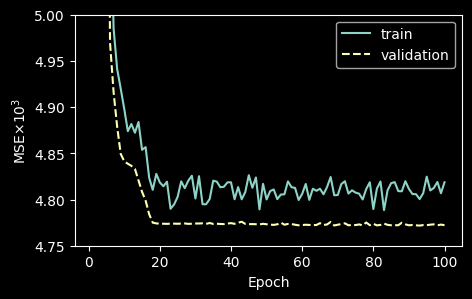

In [89]:
# Кривая обучения
fig, ax0 = plt.subplots(1, 1, figsize=(5, 3))

ax0.plot(range(1, n_epochs + 1), np.array(train_epochs_losses) * 1e3, label='train')
ax0.plot(range(1, n_epochs + 1), np.array(val_epochs_losses) * 1e3, linestyle='dashed', label='validation')

ax0.set_ylim([4.75, 5.0])
ax0.set_ylabel(loss_func_name + r'$\times 10^3$')
ax0.set_xlabel('Epoch')
ax0.legend()

plt.show()

In [80]:
# обучаемые параметры
print('Trained optical setup:')

for ind, el in enumerate(trainable_setup.net):
    if isinstance(el, elements.FreeSpace):
        print(f'\t{ind + 1} FreeSpace:\td = {el.distance * 100:.3f} cm')
    if isinstance(el, elements.ThinLens):
        print(f'\t{ind + 1} ThinLens:\tF = {el.focal_length * 100:.3f} cm')

Trained optical setup:
	1 FreeSpace:	d = 1.707 cm
	2 ThinLens:	F = 4.171 cm
	3 FreeSpace:	d = 2.203 cm
	4 ThinLens:	F = 5.752 cm
	5 FreeSpace:	d = 4.750 cm


In [81]:
print('Target optical setup:')

for ind, el in enumerate(TARGET_4F_SYSTEM.net):
    if isinstance(el, elements.FreeSpace):
        print(f'\t{ind + 1} FreeSpace:\td = {el.distance * 100:.3f} cm')
    if isinstance(el, elements.ThinLens):
        print(f'\t{ind + 1} ThinLens:\tF = {el.focal_length * 100:.3f} cm')

Target optical setup:
	1 FreeSpace:	d = 4.000 cm
	2 ThinLens:	F = 4.000 cm
	3 FreeSpace:	d = 8.000 cm
	4 ThinLens:	F = 4.000 cm
	5 FreeSpace:	d = 4.000 cm


# 5. Сравнение полученной системы с целевой 4F-системой

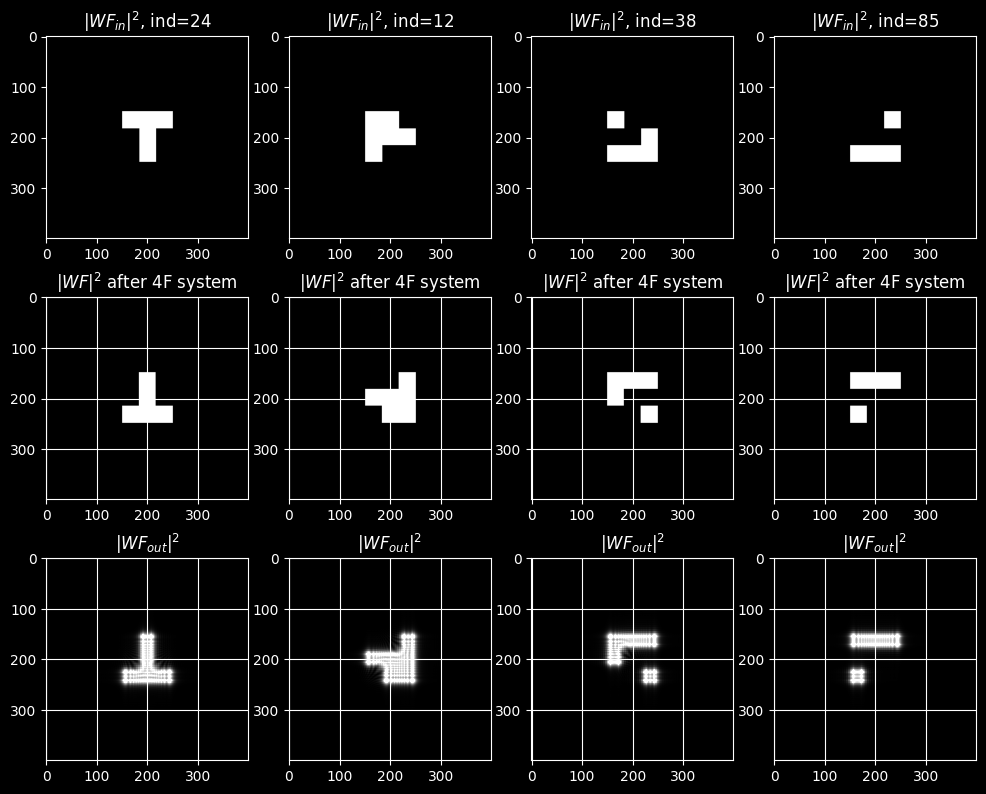

In [ ]:
# отображение нескольких ПРИМЕРОВ из ВАЛИДАЦИОННОГО набора
# выбор индексов изображений (из валидационного набора) для отображения

# random.seed(78)
# val_examples_ids = random.sample(range(len(val_set)), n_examples)

n_lines = 3
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))

for ind_ex, ind_sample in enumerate(val_examples_ids):

    wavefront, target = val_set[ind_sample]

    axs[0][ind_ex].set_title('$|WF_{in}|^2$, ' + f'ind={ind_sample}')
    # отображение интенсивности входного волнового фронта
    axs[0][ind_ex].imshow(
        wavefront.intensity, cmap='gray',
        vmin=0, vmax=1
    )

    # целевой вывод (после 4F-системы)
    axs[1][ind_ex].set_title('$|WF|^2$ после 4F-системы')
    axs[1][ind_ex].imshow(
        target, cmap='gray',
        vmin=0, vmax=1
    )
    axs[1][ind_ex].grid(True)

    # вывод обученной сети
    with torch.no_grad():
        output = trainable_setup.net(wavefront)
    axs[2][ind_ex].set_title('$|WF_{out}|^2$')
    axs[2][ind_ex].imshow(
        output, cmap='gray',
        vmin=0, vmax=1
    )
    axs[2][ind_ex].grid(True)

plt.show()
